In [1]:
import numpy as np
import pandas as pd
from scipy import linalg as la
from matplotlib import pyplot as plt

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.



data =


,x1,x2,x3
0,-0.688155,-4.938774,-6.315084
1,-0.591097,2.474853,1.292658
2,-0.253106,0.133316,-0.372895
3,1.385759,-1.723710,1.047808
4,0.237486,-3.985396,-3.510424
...,...,...,...
4995,0.285983,-1.930046,-1.358080
4996,-1.434818,2.149797,-0.719838
4997,1.292548,-1.543137,1.041959
4998,-0.599348,0.075264,-1.123432


cov = 
 [[ 1.01491753  1.00266222  3.03249728]
 [ 1.00266222 10.15163386 12.1569583 ]
 [ 3.03249728 12.1569583  18.22195285]]


--- Eig --- 
cov = V lambd V.T
lambd =
 [2.73486825e+01 2.03982177e+00 1.81284435e-17]

V =
 [[-0.1150459   0.56577184 -0.81649658]
 [-0.57788025 -0.70667372 -0.40824829]
 [-0.80797206  0.42486996  0.40824829]]


--- SVD --- 
cov = U s Vh
U =
 [[-0.1150459   0.56577184 -0.81649658]
 [-0.57788025 -0.70667372 -0.40824829]
 [-0.80797206  0.42486996  0.40824829]] 

s =
 [2.73486825e+01 2.03982177e+00 9.32678086e-16] 

Vh =
 [[-0.1150459  -0.57788025 -0.80797206]
 [ 0.56577184 -0.70667372  0.42486996]
 [-0.81649658 -0.40824829  0.40824829]] 

Are the two solutions close? [True, True]


--- PCA analysis ---
The first two components explain a fraction of (1 - 3.2e-17) of the total variability.
That makes sense because the feature x3 is linearly dependent on features x1 and x2.

s_red =
 [27.34868248  2.03982177  0.        ] 


The new variables have these relation wi

,y1,y2,y3
0,8.035601,0.417673,8.701142e-16
1,-2.406597,-1.534128,-5.066239e-16
2,0.253367,-0.395843,-7.840013e-17
3,-0.009927,2.447307,6.700604e-16
4,5.112084,1.459264,7.962315e-16
...,...,...,...
4995,2.179725,0.948707,2.654116e-16
4996,-0.495647,-2.636822,-7.594121e-16
4997,-0.098828,2.264479,5.022149e-16
4998,0.933161,-0.869594,-2.220446e-16




data_new (without the useless variables) =


,y1,y2
0,8.035601,0.417673
1,-2.406597,-1.534128
2,0.253367,-0.395843
3,-0.009927,2.447307
4,5.112084,1.459264
...,...,...
4995,2.179725,0.948707
4996,-0.495647,-2.636822
4997,-0.098828,2.264479
4998,0.933161,-0.869594


From the scatter plots in the rotated basis it is possible to see that only two 
variables over the original three are independent. In fact, in the new basis it 
is posssible to see that the y3 variable is almost zero (it is near the machine precsion).
The three orange plots have the same scale along the vertical variable to show
easily that y3 is zero for every value of y1 and y2. In other words, in the new basis the
last variable (i.e., y3) is of no importance and y1 and y2 describe completely the dataset.
This conclusion agrees with the way the dataset was originally constructed.


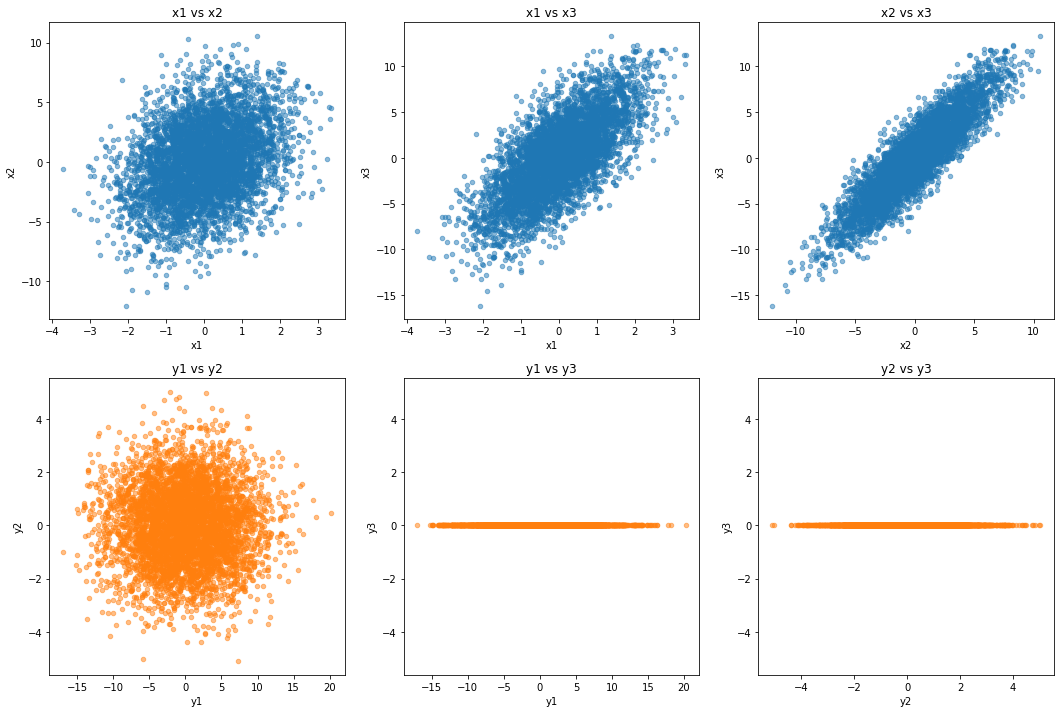

In [2]:
N = 5000

# generate dataset
data = pd.DataFrame(data=np.random.randn(N), columns=['x1'])
data['x2'] = data['x1'] + (3 * np.random.randn(N))
data['x3'] = 2 * data['x1'] + data['x2']
print("\ndata ="); display(data)


# find eigenvectors and eigenvalues
cov = data.cov()
lambd, V = la.eig(cov)
print("cov = \n", cov.values)

# sort to have the eigenvalues in descending order (for future comparisons)
idx = lambd.argsort()[::-1]
lambd = np.real_if_close(lambd[idx])
V = V[:, idx]
print("\n\n--- Eig --- \ncov = V lambd V.T")
print("lambd =\n", lambd)
print("\nV =\n", V)

# SVD decomposition and comparisons with the result of la.eig()
U, s, Vh = la.svd(cov)
print("\n\n--- SVD --- \ncov = U s Vh")
print("U =\n", U, "\n\ns =\n", s, "\n\nVh =\n", Vh, "\n")
print("Are the two solutions close?", [np.allclose(V,U), np.allclose(lambd,s)])


# PCA dimensionality reduction
PCprob = s[2] / np.sum(s)
print("\n\n--- PCA analysis ---\nThe first two components explain a fraction of (1 - %1.1e) of the total variability." % (PCprob))
print("That makes sense because the feature x3 is linearly dependent on features x1 and x2.")

s_red = np.concatenate((s[:2],0), axis=None)
print("\ns_red =\n", s_red, "\n\n")

print("The new variables have these relation with the previous ones:")
for i in range(3):
    s = "y"+str(i+1) + " = "
    for j in range(3):
        s = s + "+ ("+str(round(U[j,i],3))+" * x"+str(j+1)+") "
    print(s)
    


# redefine and plot data
data_new = pd.DataFrame(np.dot(data, U), columns=['y1','y2','y3'])
print("\n\ndata_new ="); display(data_new)
print("\n\ndata_new (without the useless variables) ="); display(data_new.loc[:,['y1','y2']])

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
Nax = 0
for i in range(3):
    for j in range(i+1,3):
        data.plot.scatter(x='x'+str(i+1), y='x'+str(j+1), ax=axs[0,Nax],\
                          title='x'+str(i+1)+' vs '+'x'+str(j+1), alpha=0.5)
        data_new.plot.scatter(x='y'+str(i+1), y='y'+str(j+1), ax=axs[1,Nax],\
                              title='y'+str(i+1)+' vs '+'y'+str(j+1), alpha=0.5, c='C1')
        # to ease visualization of differences
        axs[1,Nax].set_ylim(axs[1,0].get_ylim())
        Nax += 1


print("From the scatter plots in the rotated basis it is possible to see that only two \n"
      "variables over the original three are independent. In fact, in the new basis it \n"
      "is posssible to see that the y3 variable is almost zero (it is near the machine precsion).\n"
      "The three orange plots have the same scale along the vertical variable to show\n"
      "easily that y3 is zero for every value of y1 and y2. In other words, in the new basis the\n"
      "last variable (i.e., y3) is of no importance and y1 and y2 describe completely the dataset.\n"
      "This conclusion agrees with the way the dataset was originally constructed.")


2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before


dataD =


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,-0.688155,-4.938774,-6.315084,-0.040156,-0.000490,0.019490,0.005658,0.003404,0.012368,-0.021798,-0.004319,-0.007480,0.010113
1,-0.591097,2.474853,1.292658,-0.000006,-0.019619,0.041509,0.023389,0.008762,-0.017547,0.029240,-0.014088,0.001532,0.012578
2,-0.253106,0.133316,-0.372895,0.011694,0.003094,0.002672,-0.003857,0.027184,0.019229,-0.005936,-0.018880,-0.009090,0.024731
3,1.385759,-1.723710,1.047808,-0.010386,0.002981,0.014010,0.016218,-0.023730,-0.003417,0.028386,0.013619,0.007688,-0.000175
4,0.237486,-3.985396,-3.510424,0.010386,-0.013094,-0.024173,-0.000920,-0.004119,0.029337,0.032863,-0.002749,0.018697,0.050829
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.285983,-1.930046,-1.358080,0.000038,0.006069,0.022102,-0.008490,0.017312,0.017340,-0.018917,0.048474,0.027759,-0.036970
4996,-1.434818,2.149797,-0.719838,-0.005522,-0.007687,0.010318,-0.027235,0.015749,0.027549,-0.008028,0.001349,0.003564,0.002671
4997,1.292548,-1.543137,1.041959,0.018373,-0.028859,-0.019108,0.007271,0.017544,-0.011065,-0.032089,0.007882,-0.014159,-0.005706
4998,-0.599348,0.075264,-1.123432,0.014023,0.008570,-0.024825,-0.016746,0.024566,-0.008566,0.025322,-0.023089,-0.010268,0.004223


covD[:4,:4] = 
 [[ 1.01491753e+00  1.00266222e+00  3.03249728e+00 -4.02417449e-05]
 [ 1.00266222e+00  1.01516339e+01  1.21569583e+01  1.05572404e-03]
 [ 3.03249728e+00  1.21569583e+01  1.82219529e+01  9.75240554e-04]
 [-4.02417449e-05  1.05572404e-03  9.75240554e-04  4.13272194e-04]]


--- SVD --- 
covD = UD sD VhD

UD[:4,:4] =
 [[-1.15045901e-01  5.65771763e-01 -7.52769559e-05 -8.16206940e-05]
 [-5.77880246e-01 -7.06673624e-01  9.00345006e-05  6.89519184e-05]
 [-8.07972049e-01  4.24869903e-01 -6.05194112e-05 -9.42894695e-05]
 [-5.09508827e-05 -1.73808210e-04  6.59995593e-01 -1.76900960e-01]] 

sD =
 [2.73486833e+01 2.03982231e+00 4.31495344e-04 4.18494946e-04
 4.10762014e-04 4.02958292e-04 4.01286457e-04 3.98400022e-04
 3.90770397e-04 3.88024606e-04 3.85004694e-04 3.76451019e-04
 1.29417594e-16] 

VhD[:4,:4] =
 [[-1.15045901e-01 -5.77880246e-01 -8.07972049e-01 -5.09508827e-05]
 [ 5.65771763e-01 -7.06673624e-01  4.24869903e-01 -1.73808210e-04]
 [-7.52769559e-05  9.00345006e-05 -6.05194

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13
0,8.035605,0.417683,-0.030804,-0.000317,-0.029681,-0.011579,0.015259,-0.007631,-0.003959,0.007747,-0.020188,-0.005343,-1.382211e-17
1,-2.406598,-1.534119,0.014710,0.014996,-0.040879,-0.013334,-0.008413,0.035300,0.018644,0.004215,0.002252,0.017334,6.489419e-16
2,0.253367,-0.395831,0.019552,-0.014388,-0.019768,-0.015303,-0.007633,-0.026432,-0.000295,0.019997,-0.000096,-0.001193,2.159978e-16
3,-0.009925,2.447306,0.002592,0.023021,-0.003934,0.017126,-0.001013,0.025470,0.012520,-0.012252,-0.020062,0.001373,-1.221007e-15
4,5.112085,1.459266,0.024007,-0.003122,0.006413,0.016723,-0.028747,-0.024561,0.042412,0.021554,-0.027962,0.019108,-7.356062e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.179723,0.948706,-0.005613,0.026623,0.020972,-0.036166,0.032190,-0.015089,0.006614,-0.044200,0.000990,-0.017412,-5.045815e-16
4996,-0.495648,-2.636812,-0.008609,0.006997,-0.011943,-0.013222,-0.001113,-0.037107,0.011784,-0.003508,0.006678,-0.008278,1.439639e-15
4997,-0.098831,2.264471,-0.003721,-0.038259,0.012457,-0.017793,0.009287,-0.005438,-0.010273,-0.011751,0.017701,0.027521,-1.213447e-15
4998,0.933157,-0.869585,0.026781,-0.007320,0.002771,0.017239,-0.002408,-0.009002,0.005219,0.031233,0.031464,-0.002917,4.868901e-16




dataD_new (without the useless variables) =


,y1,y2
0,8.035605,0.417683
1,-2.406598,-1.534119
2,0.253367,-0.395831
3,-0.009925,2.447306
4,5.112085,1.459266
...,...,...
4995,2.179723,0.948706
4996,-0.495648,-2.636812
4997,-0.098831,2.264471
4998,0.933157,-0.869585


From the scatter plots in the rotated basis it is possible to see that only 12 
variables over the original 13 are independent (only some of them are shown).
In fact, in the new basis it is posssible to see that the last y13 variable is almost zero.
The last three orange plots have the same scale along the vertical variable to show
easily that y13 is zero for every value of the other y variables.
In other words, in the new basis the last variable (i.e., y13) is of no importance.
I chose the disposition of the plots such that the variables of the upper (blue) plot 
corresponds to the variables of the lower (orange) plot. x2 and x1 are the variables with greater 
stds (in decreasing order), so they are mapped respectively on y1 and y2 (the two with bigger 
eigenvalues, in decreasing order). x3 is mapped on y13 (which has the smallest eigenvalue).
The other variables are mapped between y2 and y13 and are also negligeable in the PCA due to 
their small stds compared to x1 and x2 stds. Howe

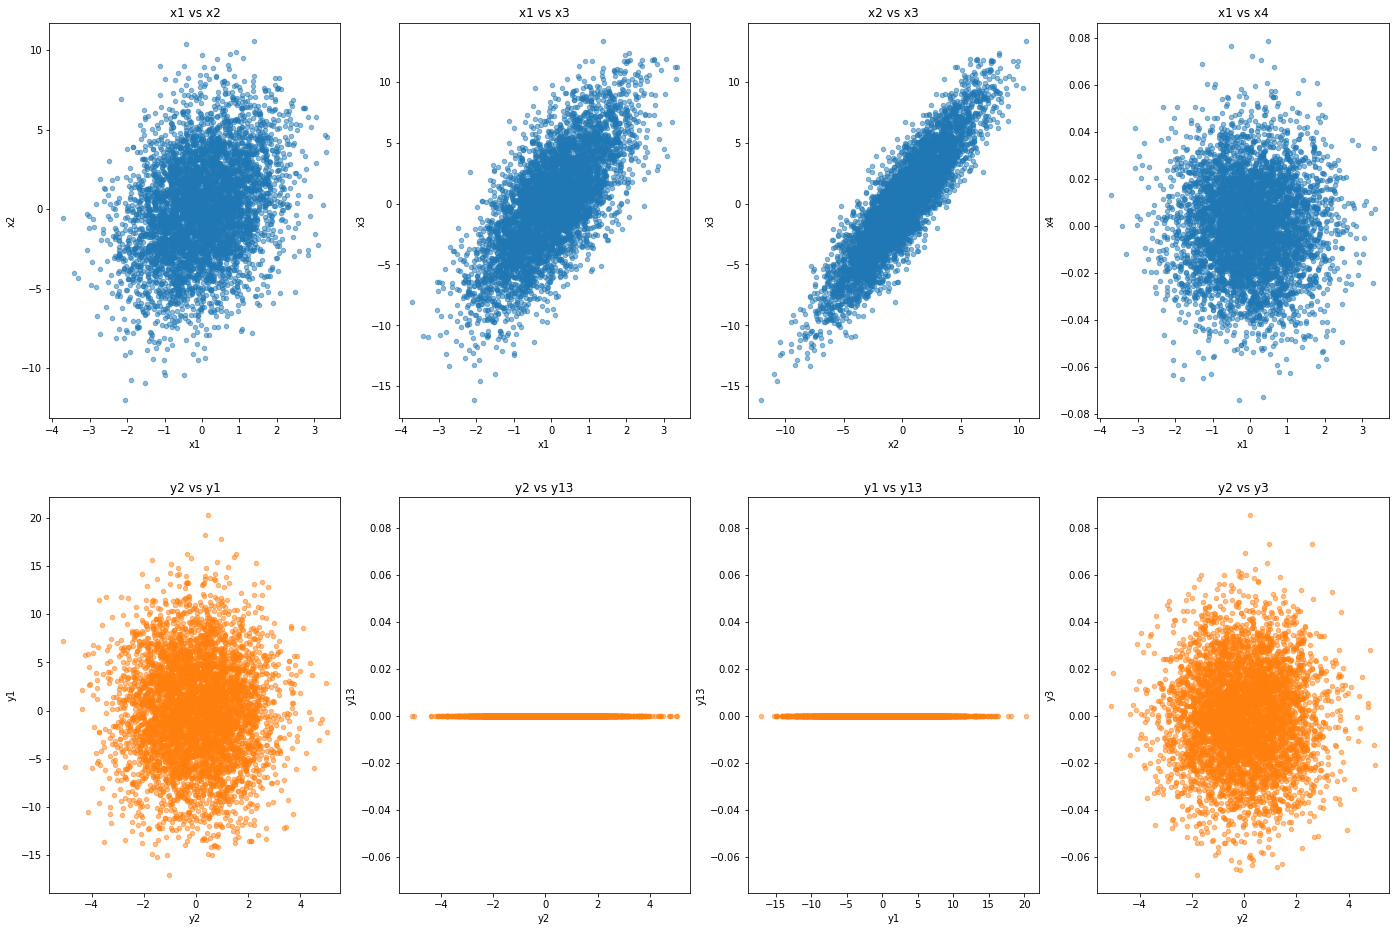

In [3]:
nD = 10
std = 1/50

# generate data
dataD = pd.concat([data, pd.DataFrame(data=std*np.random.randn(N,nD), columns=['x'+str(j+4) for j in range(nD)])], axis=1)
print("\ndataD ="); display(dataD)

# SVD decomposition
covD = dataD.cov()
print("covD[:4,:4] = \n", covD.values[:4,:4])
UD, sD, VhD = la.svd(covD)
print("\n\n--- SVD --- \ncovD = UD sD VhD")
print("\nUD[:4,:4] =\n", UD[:4,:4], "\n\nsD =\n", sD, "\n\nVhD[:4,:4] =\n", VhD[:4,:4], "\n")

# PCA dimensionality reduction
PCprobD = np.sum(sD[2:]) / np.sum(sD)
print("\n\n--- PCA analysis ---\nThe first two components explain a fraction of (1 - %2.2e) of the total variability." % (PCprobD))
sD_red = np.concatenate((sD[:2],np.zeros(len(sD)-2)), axis=None)
print("\nsD_red =\n", sD_red)    
    
# redefine and plot data
dataD_new = pd.DataFrame(np.dot(dataD, UD), columns=[w.replace('x','y') for w in dataD.columns])
print("\n\ndataD_new ="); display(dataD_new)
print("\n\ndataD_new (without the useless variables) ="); display(dataD_new.loc[:,['y1','y2']])

    

figD, axsD = plt.subplots(nrows=2, ncols=4, figsize=(24,16))
Nax = 0
for i,j in [(1,2),(1,3),(2,3),(1,4)]:
    dataD.plot.scatter(x='x'+str(i), y='x'+str(j), ax=axsD[0,Nax],\
                       title='x'+str(i)+' vs '+'x'+str(j), alpha=0.5)
    Nax += 1

Nax = 0
for i,j in [(2,1),(2,nD+3),(1,nD+3),(2,3)]:
    dataD_new.plot.scatter(x='y'+str(i), y='y'+str(j), ax=axsD[1,Nax],\
                           title='y'+str(i)+' vs '+'y'+str(j), alpha=0.5, c='C1')
    Nax += 1
    
for a in axsD[1,1:-1]:
    a.set_ylim(axsD[1,-1].get_ylim())
    
print("From the scatter plots in the rotated basis it is possible to see that only "+str(nD+2)+" \n"
      "variables over the original "+str(nD+3)+" are independent (only some of them are shown).\n"
      "In fact, in the new basis it is posssible to see that the last y"+str(nD+3)+" variable is almost zero.\n"
      "The last three orange plots have the same scale along the vertical variable to show\n"
      "easily that y"+str(nD+3)+" is zero for every value of the other y variables.\n"
      "In other words, in the new basis the last variable (i.e., y"+str(nD+3)+") is of no importance.\n"
      "I chose the disposition of the plots such that the variables of the upper (blue) plot \n"
      "corresponds to the variables of the lower (orange) plot. x2 and x1 are the variables with greater \n"
      "stds (in decreasing order), so they are mapped respectively on y1 and y2 (the two with bigger \n"
      "eigenvalues, in decreasing order). x3 is mapped on y"+str(nD+3)+" (which has the smallest eigenvalue).\n"
      "The other variables are mapped between y2 and y"+str(nD+3)+" and are also negligeable in the PCA due to \n"
      "their small stds compared to x1 and x2 stds. However, even if these additional "+str(nD)+" random variables are \n"
      "negligeable in PCA, the plots (the last orange one for instance) show that they are not correlated with \n"
      "the two principal variables (y1 and y2).")


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.



realdata =


,x,y
t,,
0.000000,0.000000e+00,0.034930
0.001000,6.284401e-03,0.069973
0.002000,1.256855e-02,0.009549
0.003001,1.885221e-02,-0.024243
0.004001,2.513512e-02,-0.006816
...,...,...
4.995999,-2.513512e-02,0.026822
4.996999,-1.885221e-02,0.053131
4.998000,-1.256855e-02,0.023833


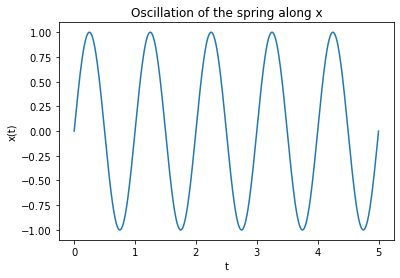

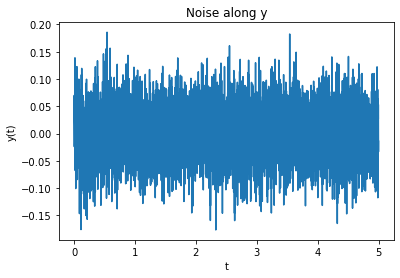

data (got from cameras) =


,cam0,cam1,cam2,cam3,cam4
t,,,,,
0.000000,0.013640,0.004768,0.007883,0.000116,0.024998
0.001000,0.031645,0.003439,0.015870,-0.000293,0.051279
0.002000,0.012368,-0.010920,0.002312,-0.001020,0.009241
0.003001,0.003492,-0.021643,-0.005235,-0.001659,-0.013738
0.004001,0.014616,-0.025375,-0.001224,-0.002127,-0.000062
...,...,...,...,...,...
4.995999,-0.006804,0.028105,0.005739,0.002194,0.014380
4.996999,0.007789,0.025586,0.011755,0.001755,0.034411
4.998000,0.000667,0.015476,0.005221,0.001132,0.014648




--- SVD --- 
cov = U s Vh


s =
 [7.30924555e-01 1.69256763e-03 1.24383424e-17 2.62762124e-18
 1.23504457e-18] 



--- PCA analysis ---
The first two components explain a fraction of (1 - 2.23e-17) of the total variability.

s_red =
 [0.73092456 0.00169257 0.         0.         0.        ]


data_new =


,camy0,camy1,camy2,camy3,camy4
t,,,,,
0.000000,-0.007952,-0.028855,-4.403383e-16,7.616960e-17,5.812231e-17
0.001000,-0.023528,-0.057803,-8.797954e-16,1.525043e-16,1.177140e-16
0.002000,-0.017372,-0.007889,-1.178396e-16,1.977881e-17,1.584018e-17
0.003001,-0.017277,0.020025,3.094882e-16,-5.195977e-17,-3.906164e-17
0.004001,-0.028842,0.005628,8.812200e-17,-1.605794e-17,-1.141448e-17
...,...,...,...,...,...
4.995999,0.024287,-0.022155,-3.404693e-16,5.860671e-17,4.434307e-17
4.996999,0.010701,-0.043888,-6.713434e-16,1.152778e-16,8.794529e-17
4.998000,0.009772,-0.019687,-3.024336e-16,5.275162e-17,3.944731e-17




data_new (without the useless variables) =


,camy0,camy1
t,,
0.000000,-0.007952,-0.028855
0.001000,-0.023528,-0.057803
0.002000,-0.017372,-0.007889
0.003001,-0.017277,0.020025
0.004001,-0.028842,0.005628
...,...,...
4.995999,0.024287,-0.022155
4.996999,0.010701,-0.043888
4.998000,0.009772,-0.019687


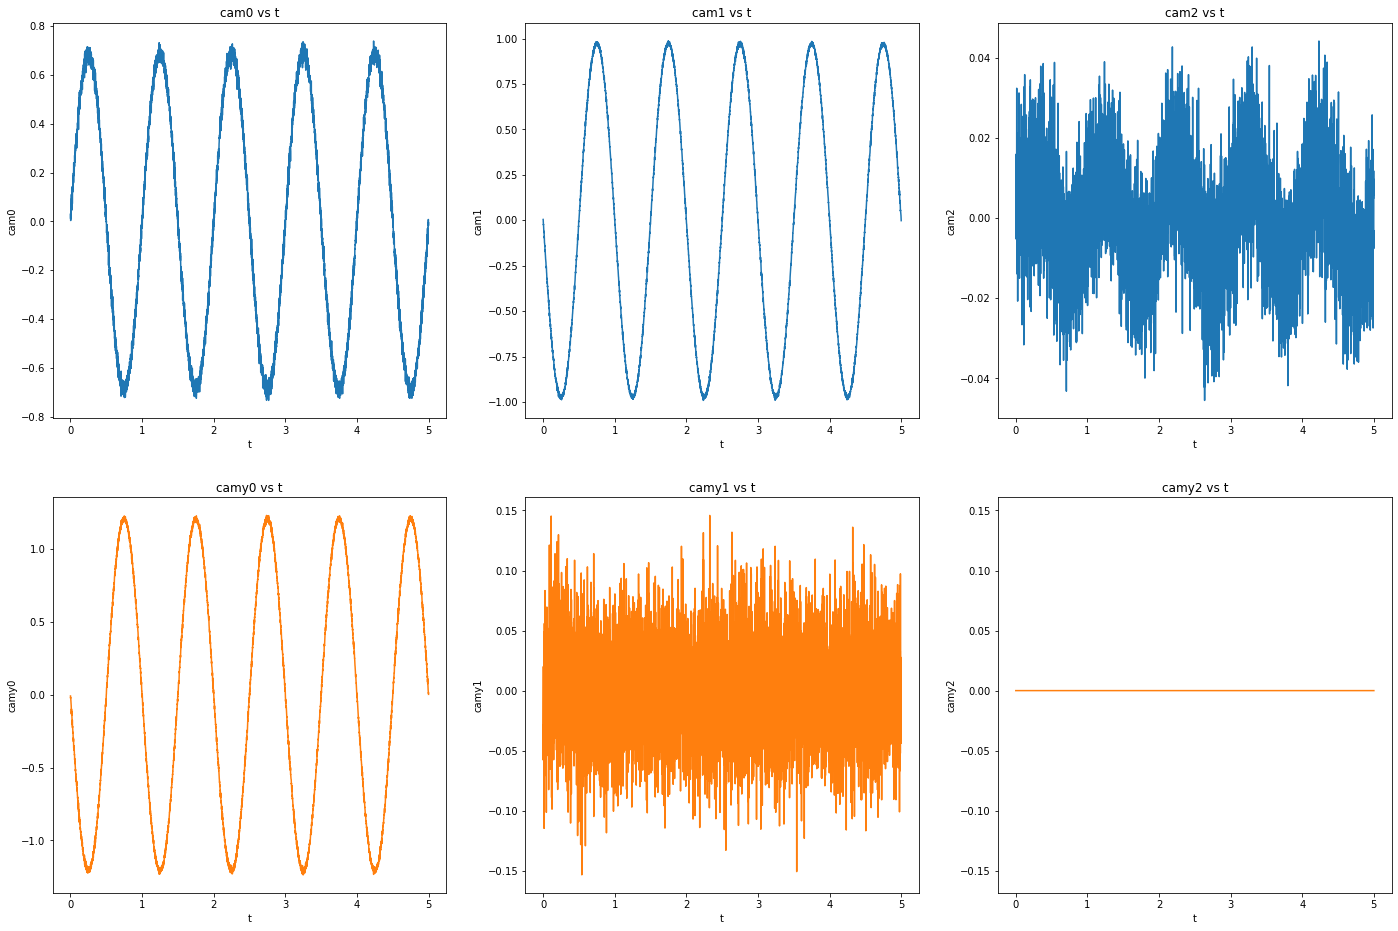

From the blue plots it is possible to see that all the cameras show similar plots, which are 
scaled variants of the original one (the oscillation along x). The orange plots in the rotated basis 
and the eigenvalues show that only two variables over the original 5 are independent.
camy0 represents the best reconstructed estimate of the original motion. It is not an accurate 
reconstruction because the cameras are not enough, but we expect that an higher number of cameras 
allows a better reconstruction of the spring motion. camy1 represents instead the random noise 
along the y axis.


In [4]:
# parameters
ncam = 5 # cameras
T = 1 # period
omega = 2*np.pi/T
Npoints = 5000
sigma = 0.05

# build data
realdata = pd.DataFrame(columns=['t','x','y'])
realdata['t'] = np.linspace(0, 5*T, Npoints)
realdata['x'] = np.sin(omega*realdata['t'])
realdata['y'] = sigma * np.random.randn(Npoints)
realdata.set_index(keys='t', inplace=True)
print("\nrealdata ="); display(realdata)
realdata.plot(y='x', ylabel='x(t)', title='Oscillation of the spring along x', legend=False)
realdata.plot(y='y', ylabel='y(t)', title='Noise along y', legend=False)
plt.show()

# directions = [[theta1, phi1],[...]]
camdir = np.random.uniform(high=np.pi, size=(ncam,2))
data = pd.DataFrame(columns=['cam'+str(i) for i in range(ncam)])

for i in range(ncam):
    theta_i = camdir[i,0]
    phi_i = camdir[i,1]
    data['cam'+str(i)] = np.sin(theta_i)*np.cos(phi_i)*realdata['x'] +\
                         np.sin(theta_i)*np.sin(phi_i)*realdata['y']
    

# plot the simulated data of cameras
print("data (got from cameras) ="); display(data)


# SVD decomposition
cov = data.cov()
U, s, Vh = la.svd(cov)
print("\n\n--- SVD --- \ncov = U s Vh")
print("\n\ns =\n", s, "\n")

# PCA dimensionality reduction
PCprob = np.sum(s[2:]) / np.sum(s)
print("\n\n--- PCA analysis ---\nThe first two components explain a fraction of (1 - %2.2e) of the total variability." % (PCprob))
s_red = np.concatenate((s[:2],np.zeros(len(s)-2)), axis=None)
print("\ns_red =\n", s_red)


# redefine and plot data
data_new = pd.DataFrame(data=np.dot(data, U), columns=[w.replace('cam','camy') for w in data.columns], index=data.index)
print("\n\ndata_new ="); display(data_new)
print("\n\ndata_new (without the useless variables) ="); display(data_new.loc[:,['camy0','camy1']])

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,16))
Nax = 0
for i in range(3):
    data.plot(y='cam'+str(i), ax=axs[0,Nax], title='cam'+str(i)+' vs t', ylabel='cam'+str(i), legend=False)
    data_new.plot(y='camy'+str(i), ax=axs[1,Nax], title='camy'+str(i)+' vs t', color='C1', ylabel='camy'+str(i), legend=False)
    Nax += 1
axs[1,2].set_ylim(axs[1,1].get_ylim())
plt.show()


print("From the blue plots it is possible to see that all the cameras show similar plots, which are \n"
      "scaled variants of the original one (the oscillation along x). The orange plots in the rotated basis \n"
      "and the eigenvalues show that only two variables over the original "+str(ncam)+" are independent.\n"
      "camy0 represents the best reconstructed estimate of the original motion. It is not an accurate \n"
      "reconstruction because the cameras are not enough, but we expect that an higher number of cameras \n"
      "allows a better reconstruction of the spring motion. camy1 represents instead the random noise \n"
      "along the y axis.")


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 


data =


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h




--- SVD --- 
cov = U s Vh


s =
 [6.57979140e+03 3.85387048e+03 2.01638313e+03 1.32675968e+03
 6.10187259e+02 4.33599171e+02 1.17330074e+02 8.63965822e-02
 1.07363851e-02 3.85322859e-04] 



--- PCA analysis ---
The first four components explain a fraction of 0.92226 of the total variability.

s_red =
 [6579.79139978 3853.87048182 2016.38312842 1326.75967836    0.
    0.            0.            0.            0.            0.        ]


data_new =


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,-66.770898,55.598192,13.782929,-23.910855,48.094253,-9.214111,2.965775,-1.988366,-1.348682,-0.110405,g
1,-174.588255,109.891592,33.987128,7.499934,27.852709,-11.070329,-0.790826,-1.645922,-1.493061,-0.035337,g
2,-243.440502,111.280406,162.323113,-158.011234,84.034269,-48.769028,64.164079,-1.422655,-1.420320,-0.093817,g
3,-97.933588,58.003670,42.243997,-4.311444,20.074677,-8.227096,-0.864271,-1.631393,-1.515425,-0.065159,g
4,-331.900019,145.558113,40.844236,7.840250,39.158539,20.131992,1.603987,-1.826953,-1.433084,-0.094436,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,-92.565079,56.976797,19.077462,-2.310343,13.245568,2.295051,2.197477,-1.845665,-1.603136,-0.054561,h
19016,-201.476793,119.750120,61.301766,11.541361,110.710890,-5.524871,-9.893790,-1.761521,-1.293937,-0.113235,h
19017,-247.779335,105.154801,10.006955,-23.135649,55.004428,-10.611179,17.688940,-2.074503,-1.339143,-0.110234,h
19018,-396.071821,87.969150,157.616635,-34.216568,106.826323,-67.841820,23.584568,-2.322530,-1.430525,-0.083373,h




data_new (without the useless variables) =


,y0,y1,y2,y3,y10
0,-66.770898,55.598192,13.782929,-23.910855,g
1,-174.588255,109.891592,33.987128,7.499934,g
2,-243.440502,111.280406,162.323113,-158.011234,g
3,-97.933588,58.003670,42.243997,-4.311444,g
4,-331.900019,145.558113,40.844236,7.840250,g
...,...,...,...,...,...
19015,-92.565079,56.976797,19.077462,-2.310343,h
19016,-201.476793,119.750120,61.301766,11.541361,h
19017,-247.779335,105.154801,10.006955,-23.135649,h
19018,-396.071821,87.969150,157.616635,-34.216568,h


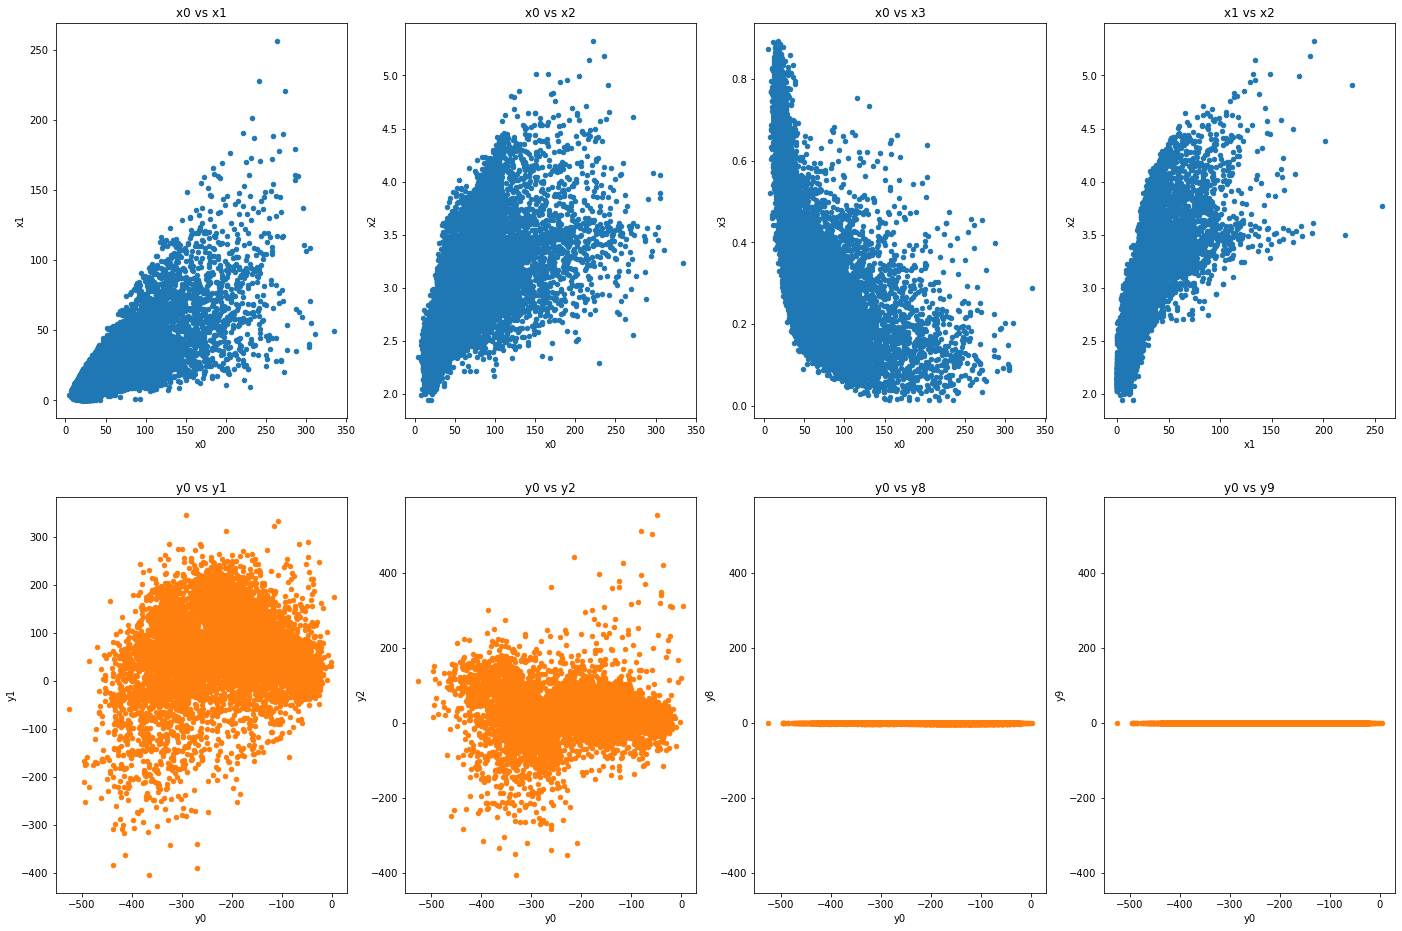

The majority of the variability (1 - 6.53e-06) is explained by the first seven eigenvalues of the 
covariance matrix. However, also the first four eigenvalues explains a fraction of 0.92 of the total 
variability.


In [6]:
# import and show data
data = pd.read_csv("~/data/magic04.data", header=None)
data.columns = ['x'+str(c) for c in data.columns]
SVDcol = data.columns.drop('x10')
print("\ndata ="); display(data)


# SVD decomposition
cov = data.loc[:,SVDcol].cov()
U, s, Vh = la.svd(cov)
print("\n\n--- SVD --- \ncov = U s Vh")
print("\n\ns =\n", s, "\n")

# PCA dimensionality reduction
PCprob = np.sum(s[:4]) / np.sum(s)
print("\n\n--- PCA analysis ---\nThe first four components explain a fraction of %2.5f of the total variability." % (PCprob))
s_red = np.concatenate((s[:4],np.zeros(len(s)-4)), axis=None)
print("\ns_red =\n", s_red)


# redefine and plot data
data_new = pd.concat([pd.DataFrame(data=np.dot(data.loc[:,SVDcol], U)), data.loc[:,'x10']],\
                     axis=1, ignore_index=True)
data_new.columns = [w.replace('x','y') for w in SVDcol]+['y10']
print("\n\ndata_new ="); display(data_new)
print("\n\ndata_new (without the useless variables) ="); display(data_new.loc[:,['y0','y1','y2','y3','y10']])


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24,16))
Nax = 0
for i,j in [(0,1),(0,2),(0,3),(1,2)]:
    data.plot.scatter(x='x'+str(i), y='x'+str(j), ax=axs[0,Nax], title='x'+str(i)+' vs '+'x'+str(j))
    Nax += 1

Nax = 0
for i,j in [(0,1),(0,2),(0,8),(0,9)]:
    data_new.plot.scatter(x='y'+str(i), y='y'+str(j), ax=axs[1,Nax], title='y'+str(i)+' vs '+'y'+str(j), color='C1')
    Nax += 1
    axs[1,2].set_ylim(axs[1,1].get_ylim())
    axs[1,3].set_ylim(axs[1,1].get_ylim())
    
plt.show()


print("The majority of the variability (1 - %2.2e) is explained by the first seven eigenvalues of the \n"
      "covariance matrix. However, also the first four eigenvalues explains a fraction of %2.2f of the total \n"
      "variability."%
      (np.sum(s[7:]) / np.sum(s), np.sum(s[:4]) / np.sum(s)))